# **BMEN 4470 - Deep Learning for Biomedical Signal Processing**
# **Homework 2: Basics of Modeling Sequences and Temporal Convolution Networks**

Due 11:59pm on October 18th, 2021



In [ ]:
!pip install bunch
#Import
import sys
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import scipy.io as sio
from bunch import Bunch
import torch.optim as optim
from pandas import DataFrame
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.utils import weight_norm
from os.path import dirname, join as pjoin
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score

  Created wheel for bunch: filename=bunch-1.0.1-py3-none-any.whl size=7092 sha256=7af5a9f85aea95ca4da9122e22f6d73ceaa3b6d642af8cd873fcf7d3ac9de3cf
  Stored in directory: /root/.cache/pip/wheels/10/ad/12/a8818fda74a365129e0f316c41a12dead904b60534d2114448
Successfully built bunch


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Problem 1: ARMA Model** In this question, you need to apply three different Autoregressive Moving Average Model (ARMA) to the given EKG signal. Compare the input and output signals and answering the following questions. 

In [ ]:
# The EGK signal contains 100 data points
EKG_sig = [41.985077,48.505554,17.868908,-17.902781,-25.676805,2.4074743,40.308300,50.589020,22.663403,-16.953960,-32.144905,-31.155527,-23.732307,6.5244060,44.417355,58.700817,60.295696,58.277584,51.427200,24.971256,18.454710,42.659885,28.012609,13.741727,14.357091,15.576780,11.927580,-14.444111,-25.185453,-19.081909,6.6035562,17.284658,17.544495,16.928368,-6.3161540,-14.990187,10.754345,21.378378,-3.1653652,-13.225622,15.521652,54.976814,64.869339,35.326790,-5.0551395,-18.008286,-15.629535,-11.389389,15.224802,52.611454,69.125626,71.429947,69.159081,63.929958,35.759071,-1.0452937,-12.551209,9.9472542,23.483477,29.982676,53.127209,38.299618,26.093702,25.454752,0.92754990,-9.3693218,19.490158,56.732342,40.379166,1.2176796,15.432666,53.198875,38.633102,1.4428799,12.662603,25.239782,24.835445,19.891754,-6.5586896,3.0409441,15.515370,13.531504,6.8291478,-15.963812,0.38266551,33.888634,14.340966,-27.637432,-37.876808,-12.587003,-1.4763706,-1.0964720,20.268143,5.8535609,-29.653194,-16.162226,18.147284,6.5141749,-4.5157704,13.640582]

**1(a)** Moving Average model only

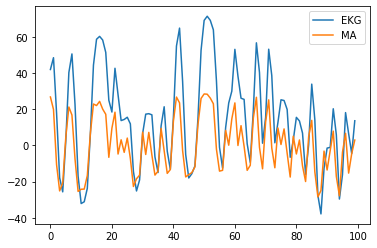

In [ ]:
# TODO: ASK @ TA HOURS

model_1 = ARIMA(EKG_sig, order=(0, 0, 1))# put the order here
model_fit_1 = model_1.fit()
residuals_1 = DataFrame(model_fit_1.resid)

# line plot of the results
plt.plot(EKG_sig, label='EKG')
plt.plot(residuals_1, label='MA')
plt.legend()
plt.show()

**1(b)** Autoregressive model only

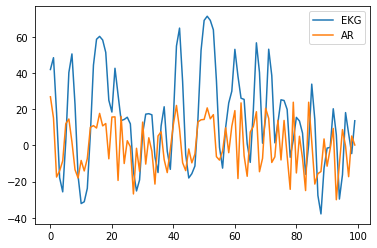

In [ ]:
# Setting autoregression parameter p = 5
model_2 = ARIMA(EKG_sig, order=(5, 0, 0)) # put the order here
model_fit_2 = model_2.fit()
residuals_2 = DataFrame(model_fit_2.resid)

# line plot of the results
plt.plot(EKG_sig, label='EKG')
plt.plot(residuals_2, label='AR')
plt.legend()
plt.show()

**1(c)** ARMA model with p = 5, q = 1

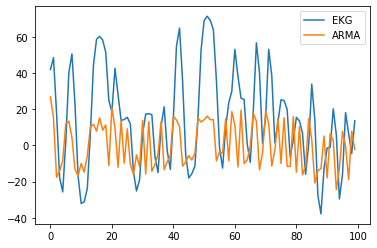

In [ ]:
# Setting autoregression parameter p = 5 and the moving average parameter q = 1
model_3 = ARIMA(EKG_sig, order=(5, 0, 1))# put the order here
model_fit_3 = model_3.fit()
residuals_3 = DataFrame(model_fit_3.resid)

# line plot of the results
plt.plot(EKG_sig, label='EKG')
plt.plot(residuals_3, label='ARMA')
plt.legend()
plt.show()

**1(d)** What are the differences between those three models? Which model works best for this EKG data? What are the pros and cons of each model? Please list at least one pro and con for each model. 

Your Answers: Generally, when we look at all the models, we can easily recognize that they look alike generally. This speaks that the trend is mostly persistent.

The main thing which allows us to differentiate between an AR and MA model is the correlation between time series objects at different time points.

1. The pure AR Model depends on the lagged values of the data we are modeling to make forecasts. A plus is that the autoregressive model uses the past forecasts to predict future values. The minus is that the correlation of x(t) and x(t-n) gradually declines with n becoming larger
2. The MA model is comletely the opposite of the AR model. A plus is that the covariance between x(t) and x(t-n) is zero for MA models. A minus is that the moving average model does not uses the past forecasts to predict the future values.
3. The combind (third) model: Takes into account both of the above factors when making predictions. However, it has more room for noise since it take into account more data in order to make the proper prediction, which is a minus.

In conclusion, the last model is the best of the three because is takes into account more data to make the prediction.

**Problem 2 Temporal Convolutional Networks** In this question, we will generate a dataset and build a simple TCN to train and test on the dataset. 

This dataset contains some data sequences: a pair of input sequences and an output. The first sequence within the input pair is composed of numbers randomly sampled from the range [0, 1]. The second input sequence within the input pair is composed of only integers: 0 or 1. This sequence must contain only two integer 1; the rest of the integers are all 0s. The output is the sum of the two values from the first input sequence corresponding to 1s in the second input sequence. 

For example, one input sequence pair can be [[0, 0.1, 0.2, 0.3, 0.4, 0.5], [0, 0, 0, 1, 1, 0]]. In this case, the final output value should be 0.3 + 0.4 = 0.7. In this example, the length of the data sequence is 6.

For the detail of TCN, see the GitHub repo [here](https://github.com/locuslab/TCN/tree/master/TCN/adding_problem).

In [ ]:
# data generator
def data_generator(N, seq_length):
    """
    Args:
        seq_length: Length of the adding problem data
        N: # of data in the set
    """
    X_num = torch.rand([N, 1, seq_length])
    X_mask = torch.zeros([N, 1, seq_length])
    Y = torch.zeros([N, 1])
    for i in tqdm(range(N)):
        positions = np.random.choice(seq_length, size=2, replace=False)
        X_mask[i, 0, positions[0]] = 1
        X_mask[i, 0, positions[1]] = 1
        Y[i,0] = X_num[i, 0, positions[0]] + X_num[i, 0, positions[1]]
    X = torch.cat((X_num, X_mask), dim=1)
    return Variable(X), Variable(Y)

In [ ]:
# generate data
X_train, Y_train = data_generator(5000, 100)
X_test, Y_test = data_generator(100, 100)

100%|██████████| 100/100 [00:00<00:00, 5314.83it/s]


In [ ]:
# define several classes for training.
class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)
        self.init_weights()

    def init_weights(self):
        self.linear.weight.data.normal_(0, 0.01)

    def forward(self, x):
        y1 = self.tcn(x)
        return self.linear(y1[:, :, -1])


class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


**2(a)** Build your TCN model below. Your model should contain two convolutional layers.

In [ ]:
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        # Your Code:

        ###### Refractor code: Only 1d Convolution etworks needed

        #########################
        # Initializing the first Convolutional Layer while appliying a weight normalization
        
        # The padding value is set to zero, because we don't want to extend the image size
        # The kernel size is set to (1, kernel_size), because we want the output to apply 1 x kernel_size matrix transformation
        # Lastly, we introduce a bias, so our model becomes more accurate after training
        self.conv1 = weight_norm(nn.Conv2d(n_inputs, n_outputs, (1, kernel_size),
                                           stride=stride, padding=0, 
                                           dilation=dilation, bias=True))
        
        # Here we apply padding with 0 additional padding in right, top, and bottom positions since we're not given those a
        self.pad = torch.nn.ZeroPad2d((padding, 0, 0, 0))

        # Applying a nonlinearity
        self.relu = nn.ReLU()

        # Applying a dropout so our TCN trains better
        self.dropout = nn.Dropout(dropout)

        # Initializing the second layer, where the n_inputs = n_outputs,
        # because we already have the output from the 1st layer
        self.conv2 = weight_norm(nn.Conv2d(n_outputs, n_outputs, (1, kernel_size),
                                           stride=stride, padding=0,
                                           dilation=dilation, bias=True))
        
        # "Connecting" the layers in a Sequential model
        self.net = nn.Sequential(self.pad, self.conv1, self.relu, self.dropout,
                                 self.pad, self.conv2, self.relu, self.dropout)
        # Creating the pooling (i.e. downsampling) layer with a kernel size = 1
        self.downsample = nn.Conv1d(
            n_inputs, n_outputs, 1
            ) if n_inputs != n_outputs else None
        
        # Applying a final nonlinearity
        self.relu = nn.ReLU()

        # Initializing the finalized weights
        self.init_weights()

        #########################

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x.unsqueeze(2)).squeeze(2)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

**2(b)** Set and adjust the training parameters to make the Average Difference you got from your network smaller than 0.008. 

In [ ]:
# initialize training parameters.
args = Bunch()
# adjustable parameters
args.epochs = 30 # put values here
args.ksize = 3 # put values here
args.batch_size = 32 # put values here
args.lr = 0.001 # put values here

# fix parameters
args.cuda = True
args.dropout = False
args.seq_len = 100
args.clip = -1
args.levels = 8
args.log_interval = 100
args.optim = 'Adam'
args.nhid = 30
args.seed = 112


Train your model. You need to use GPU for training here. To start a GPU on your Colab, follow the instruction on the slides for this assignment. Please re-run the first block after you set up the GPU. 

In [ ]:
# train the model with two conv layers
torch.manual_seed(args.seed)
if torch.cuda.is_available():
    if not args.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")

input_channels = 2
n_classes = 1
batch_size = args.batch_size
seq_length = args.seq_len
epochs = args.epochs


# Note: We use a very simple setting here (assuming all levels have the same # of channels.
channel_sizes = [args.nhid]*args.levels
kernel_size = args.ksize
dropout = args.dropout
model = TCN(input_channels, n_classes, channel_sizes, kernel_size=kernel_size, dropout=dropout)

if args.cuda:
    model.cuda()
    X_train = X_train.cuda()
    Y_train = Y_train.cuda()
    X_test = X_test.cuda()
    Y_test = Y_test.cuda()

lr = args.lr
optimizer = getattr(optim, args.optim)(model.parameters(), lr=lr)

def train(epoch):
    global lr
    model.train()
    batch_idx = 1
    total_loss = 0
    for i in range(0, X_train.size(0), batch_size):
        if i + batch_size > X_train.size(0):
            x, y = X_train[i:], Y_train[i:]
        else:
            x, y = X_train[i:(i+batch_size)], Y_train[i:(i+batch_size)]
        optimizer.zero_grad()
        output = model(x)
        loss = F.mse_loss(output, y)
        loss.backward()
        if args.clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
        optimizer.step()
        batch_idx += 1
        total_loss += loss.item()

        if batch_idx % args.log_interval == 0:
            cur_loss = total_loss / args.log_interval
            processed = min(i+batch_size, X_train.size(0))
            print('Train Epoch: {:2d} [{:6d}/{:6d} ({:.0f}%)]\tLearning rate: {:.4f}\tLoss: {:.6f}'.format(
                epoch, processed, X_train.size(0), 100.*processed/X_train.size(0), lr, cur_loss))
            total_loss = 0


def evaluate():
    model.eval()
    with torch.no_grad():
        output = model(X_test)
        test_loss = F.mse_loss(output, Y_test)
        print('\nValidation set: Average loss: {:.6f}\n'.format(test_loss.item()))
        return test_loss.item()


for ep in range(1, epochs+1):
    train(ep)
    tloss = evaluate()

Train Epoch:  1 [  3168/  5000 (63%)]	Learning rate: 0.0010	Loss: 0.215119

Validation set: Average loss: 0.193801

Train Epoch:  2 [  3168/  5000 (63%)]	Learning rate: 0.0010	Loss: 0.158347

Validation set: Average loss: 0.189650

Train Epoch:  3 [  3168/  5000 (63%)]	Learning rate: 0.0010	Loss: 0.155777

Validation set: Average loss: 0.178791

Train Epoch:  4 [  3168/  5000 (63%)]	Learning rate: 0.0010	Loss: 0.147894

Validation set: Average loss: 0.045623

Train Epoch:  5 [  3168/  5000 (63%)]	Learning rate: 0.0010	Loss: 0.013785

Validation set: Average loss: 0.005845

Train Epoch:  6 [  3168/  5000 (63%)]	Learning rate: 0.0010	Loss: 0.005188

Validation set: Average loss: 0.003732

Train Epoch:  7 [  3168/  5000 (63%)]	Learning rate: 0.0010	Loss: 0.002889

Validation set: Average loss: 0.002907

Train Epoch:  8 [  3168/  5000 (63%)]	Learning rate: 0.0010	Loss: 0.002065

Validation set: Average loss: 0.002844

Train Epoch:  9 [  3168/  5000 (63%)]	Learning rate: 0.0010	Loss: 0.0014

In [ ]:
# show the results. You will get full credit if the average differences is less than 0.02
preds = model(X_test)

total_diff = 0
for i, pred in enumerate(preds):
    total_diff += np.abs(pred.data.item() - Y_test[i].item())


print('Average Difference:', total_diff/len(Y_test))

Average Difference: 0.019321715012192726


**2(c)** Now build a TCN model with only one convolutional layer. Use the same parameter you set in 2(b) and train your network.

In [ ]:
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        # Your Code:
        
        # The padding value is set to zero, because we don't want to extend the image size
        # The kernel size is set to (1, kernel_size), because we want the output to apply 1 x kernel_size matrix transformation
        # Lastly, we introduce a bias, so our model becomes more accurate after training
        self.conv1 = weight_norm(nn.Conv2d(n_inputs, n_outputs, (1, kernel_size),
                                           stride=stride, padding=0, dilation=dilation, bias=True))
        
        # Here we apply padding with 0 additional padding in right, top, and bottom positions since we're not given those a
        self.pad = torch.nn.ZeroPad2d((padding, 0, 0, 0))

        # Applying a nonlinearity
        self.relu = nn.ReLU()

        # Applying a dropout so our TCN trains better
        self.dropout = nn.Dropout(dropout)
        
        # "Connecting" the layers in a Sequential model
        self.net = nn.Sequential(self.pad, self.conv1, self.relu, self.dropout)

        # Creating the pooling (i.e. downsampling) layer with a kernel size = 1
        self.downsample = nn.Conv1d(
            n_inputs, n_outputs, 1) if n_inputs != n_outputs else None

        # Applying a final nonlinearity
        self.relu = nn.ReLU()

        # Initializing the finalized weights
        self.init_weights()


    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x.unsqueeze(2)).squeeze(2)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


# train the model with two conv layers
torch.manual_seed(args.seed)
if torch.cuda.is_available():
    if not args.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")

input_channels = 2
n_classes = 1
batch_size = args.batch_size
seq_length = args.seq_len
epochs = args.epochs


# Note: We use a very simple setting here (assuming all levels have the same # of channels.
channel_sizes = [args.nhid]*args.levels
kernel_size = args.ksize
dropout = args.dropout
model = TCN(input_channels, n_classes, channel_sizes, kernel_size=kernel_size, dropout=dropout)

if args.cuda:
    model.cuda()
    X_train = X_train.cuda()
    Y_train = Y_train.cuda()
    X_test = X_test.cuda()
    Y_test = Y_test.cuda()

lr = args.lr
optimizer = getattr(optim, args.optim)(model.parameters(), lr=lr)


for ep in range(1, epochs+1):
    train(ep)
    tloss = evaluate()

# show the result
preds = model(X_test)

total_diff = 0
for i,pred in enumerate(preds):
    total_diff += np.abs(pred.data.item() - Y_test[i].item())


print('Average Difference:', total_diff/len(Y_test))

Train Epoch:  1 [  3168/  5000 (63%)]	Learning rate: 0.0010	Loss: 0.177250

Validation set: Average loss: 0.196835

Train Epoch:  2 [  3168/  5000 (63%)]	Learning rate: 0.0010	Loss: 0.157999

Validation set: Average loss: 0.189481

Train Epoch:  3 [  3168/  5000 (63%)]	Learning rate: 0.0010	Loss: 0.154094

Validation set: Average loss: 0.175419

Train Epoch:  4 [  3168/  5000 (63%)]	Learning rate: 0.0010	Loss: 0.123223

Validation set: Average loss: 0.053322

Train Epoch:  5 [  3168/  5000 (63%)]	Learning rate: 0.0010	Loss: 0.030291

Validation set: Average loss: 0.009050

Train Epoch:  6 [  3168/  5000 (63%)]	Learning rate: 0.0010	Loss: 0.005899

Validation set: Average loss: 0.003876

Train Epoch:  7 [  3168/  5000 (63%)]	Learning rate: 0.0010	Loss: 0.002984

Validation set: Average loss: 0.002495

Train Epoch:  8 [  3168/  5000 (63%)]	Learning rate: 0.0010	Loss: 0.001945

Validation set: Average loss: 0.001746

Train Epoch:  9 [  3168/  5000 (63%)]	Learning rate: 0.0010	Loss: 0.0014

**2(d)** Compare the result you get from 2(c) with the average difference you get from 2(b). Which network gives you a better result? Why that network gives a better result? Do you have any suggestions to improve the performance of the network that has poorer performance? 

Your Answers: We can clearly see that the first model (2b) is better, because the average difference is approximately 0.0005 while in the second model (2c) the average difference is approximately 0.01. Both differences are relatively low, however, if we compare how good the differences are, we can discover that (err(2c) / err(2b)) ~ 0.01 / 0.0005 = 20 times. This is, of course, due to the added additional layer in the first model. By training twice as much layers we've achieved 20 times better avg difference. This is also due to the fact that we have much more parameters which can be used to describe more accurately the features of the input and, therefore, make better predictions. The second network's performance can be "boosted" if we introduce more parameters, try different (more suitable) set of hyperparameters, include more neurons in each layer, or try to make a different, better type of Convolutional Layer which would suite our task better.

**Problem 3: EEGNet** In this question, we will use EEGNet, a compact convolutional network for EEG-based brain-computer interfaces. Your task is to process the given EEG data so that you can train and test the network on the dataset. For more detail about the EEGNet, please see the GitHub repo here:
https://github.com/aliasvishnu/EEGNet.

The EEG data given in this question are generated. Feel free to print or plot the data if you want to know what the dataset looks like. 



In [ ]:
# MOUNTING GOOGLE DRIVE WHERE DATA IS STORED
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Import data and save as np.array
Data = sio.loadmat('/content/drive/MyDrive/BMEN_4470_Fall_2021/HW2/Dataset/X.mat')
Label = sio.loadmat('/content/drive/MyDrive/BMEN_4470_Fall_2021/HW2/Dataset/Y.mat')
Dataset = Data['Data']
Labels = Label['Labels']
print(Dataset.shape, Labels.shape)

(300, 120, 64) (1, 300)


In [ ]:
# define the EEGNet
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        self.T = 120
        
        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, (1, 64), padding = 0)
        self.batchnorm1 = nn.BatchNorm2d(16, False)
        
        # Layer 2
        self.padding1 = nn.ZeroPad2d((16, 17, 0, 1))
        self.conv2 = nn.Conv2d(1, 4, (2, 32))
        self.batchnorm2 = nn.BatchNorm2d(4, False)
        self.pooling2 = nn.MaxPool2d(2, 4)
        
        # Layer 3
        self.padding2 = nn.ZeroPad2d((2, 1, 4, 3))
        self.conv3 = nn.Conv2d(4, 4, (8, 4))
        self.batchnorm3 = nn.BatchNorm2d(4, False)
        self.pooling3 = nn.MaxPool2d((2, 4))

        # FC Layer
        # NOTE: This dimension will depend on the number of timestamps per sample in your data.
        # here we have 120 timepoints
        self.fc1 = nn.Linear(4*2*7, 1)
        

    def forward(self, x):
        # Layer 1
        x = F.elu(self.conv1(x))
        x = self.batchnorm1(x)
        x = F.dropout(x, 0.25)
        x = x.permute(0, 3, 1, 2)
        
        # Layer 2
        x = self.padding1(x)
        x = F.elu(self.conv2(x))
        x = self.batchnorm2(x)
        x = F.dropout(x, 0.25)
        x = self.pooling2(x)
        
        # Layer 3
        x = self.padding2(x)
        x = F.elu(self.conv3(x))
        x = self.batchnorm3(x)
        x = F.dropout(x, 0.25)
        x = self.pooling3(x)
        
        # FC Layer
        x = x.view(-1, 4*2*7)
        x = torch.sigmoid(self.fc1(x))
        return x


net = EEGNet()
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters())

In [ ]:
# Define the evaluation function
def evaluate(model, X, Y, params = ["acc"]):
    results = []
    batch_size = 50
    
    predicted = []
    
    for i in range(int(len(X)/batch_size)):
        s = i*batch_size
        e = i*batch_size+batch_size
        
        inputs = Variable(torch.from_numpy(X[s:e]))
        pred = model(inputs)
        
        predicted.append(pred.data.cpu().numpy())
        
        
    inputs = Variable(torch.from_numpy(X))
    predicted = model(inputs)
    
    predicted = predicted.data.cpu().numpy()
    
    for param in params:
        if param == 'acc':
            results.append(accuracy_score(Y, np.round(predicted)))
    return results

**3(a)** Now, reshape the data so you can train it using EEGNet. To train the network, you also need to modify the network parameters to match the dimension of your training data. Please see the image [here](https://github.com/aliasvishnu/EEGNet/blob/master/EEGNet.png) for more information. 

In [ ]:
 # Your code

Dataset_tensor = torch.Tensor(Dataset)
Labels_tensor = torch.Tensor(Labels)

# print(Dataset_tensor)
# print(Labels_tensor)

X = torch.reshape(Dataset_tensor, (300, 1, 120, 64))
Y = torch.reshape(Labels_tensor, (-1, ))
print(X.shape, Y.shape)

torch.Size([300, 1, 120, 64]) torch.Size([300])


**3(b)** Now split the training, evaluation, and testing data. Please make sure you have about 80% for training, about 10% for evaluation, and about 10% for testing. Then train your network on the dataset and test it.

In [ ]:
# Your Code: 
# Please name the parameters as names given below in the print function.
TRAINING = 0.8
VALIDATION = TRAINING + 0.1
TESTING = VALIDATION + 0.1

X_length = len(X)
Y_length = len(Y)

X_train = X[0:round(X_length*TRAINING)].numpy()
y_train = Y[0:round(Y_length*TRAINING)].numpy()

X_val = X[round(X_length*TRAINING):round(X_length*VALIDATION)].numpy()
y_val = Y[round(Y_length*TRAINING):round(Y_length*VALIDATION)].numpy()

X_test = X[round(X_length*VALIDATION):round(X_length*TESTING)].numpy()
y_test = Y[round(Y_length*VALIDATION):round(Y_length*TESTING)].numpy()

print(X_train.shape, X_val.shape,X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)


(240, 1, 120, 64) (30, 1, 120, 64) (30, 1, 120, 64)
(240,) (30,) (30,)


In [ ]:
# train and test on your dataset
batch_size = 16

for epoch in range(40):  # loop over the dataset multiple times
    print("\nEpoch ", epoch)
    
    running_loss = 0.0
    for i in range(int(len(X_train)/batch_size-1)):
        s = i*batch_size
        e = i*batch_size+batch_size
        
        inputs = torch.from_numpy(X_train[s:e])
        labels = torch.FloatTensor(np.array([y_train[s:e]]).T*1.0)
        
        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)   
        loss = criterion(outputs, labels)
        loss.backward()
        
        
        optimizer.step()
        
        running_loss += loss.data
    
    # Validation accuracy
    params = ["acc"]
    print("Training Loss ", running_loss)
    print("Train - ", evaluate(net, X_train, y_train, params))
    print("Validation - ", evaluate(net, X_val, y_val, params))




Epoch  0
Training Loss  tensor(0.9099)
Train -  [0.92]
Validation -  [0.6583333333333333]

Epoch  1
Training Loss  tensor(0.6171)
Train -  [0.92]
Validation -  [0.675]

Epoch  2
Training Loss  tensor(0.5438)
Train -  [0.94]
Validation -  [0.6333333333333333]

Epoch  3
Training Loss  tensor(0.6967)
Train -  [0.9266666666666666]
Validation -  [0.6416666666666667]

Epoch  4
Training Loss  tensor(0.6681)
Train -  [0.9666666666666667]
Validation -  [0.6666666666666666]

Epoch  5
Training Loss  tensor(0.8497)
Train -  [0.9266666666666666]
Validation -  [0.6083333333333333]

Epoch  6
Training Loss  tensor(0.6041)
Train -  [0.9266666666666666]
Validation -  [0.6833333333333333]

Epoch  7
Training Loss  tensor(0.8650)
Train -  [0.92]
Validation -  [0.7333333333333333]

Epoch  8
Training Loss  tensor(1.1195)
Train -  [0.9533333333333334]
Validation -  [0.725]

Epoch  9
Training Loss  tensor(0.7213)
Train -  [0.9333333333333333]
Validation -  [0.6583333333333333]

Epoch  10
Training Loss  tensor

In [ ]:
# print test accuracy
print("Test - ", evaluate(net, X_test, y_test, params))

Test -  [0.5]


**3(c)** Now, split the data by 50% training, 40% validation, 10% testing, and retrain your model.

In [ ]:
# Your Code:
TRAINING = 0.5
VALIDATION = TRAINING + 0.4
TESTING = VALIDATION + 0.1

X_length = len(X)
Y_length = len(Y)

X_train = X[0:round(X_length*TRAINING)].numpy()
y_train = Y[0:round(Y_length*TRAINING)].numpy()

X_val = X[round(X_length*TRAINING):round(X_length*VALIDATION)].numpy()
y_val = Y[round(Y_length*TRAINING):round(Y_length*VALIDATION)].numpy()

X_test = X[round(X_length*VALIDATION):round(X_length*TESTING)].numpy()
y_test = Y[round(Y_length*VALIDATION):round(Y_length*TESTING)].numpy()

print(X_train.shape, X_val.shape,X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(150, 1, 120, 64) (120, 1, 120, 64) (30, 1, 120, 64)
(150,) (120,) (30,)


In [ ]:
# train and test on the dataset with 50% training, 40% validation, and 10% test data
batch_size = 16

for epoch in range(40):  # loop over the dataset multiple times
    print("\nEpoch ", epoch)
    
    running_loss = 0.0
    for i in range(int(len(X_train)/batch_size-1)):
        s = i*batch_size
        e = i*batch_size+batch_size
        
        inputs = torch.from_numpy(X_train[s:e])
        labels = torch.FloatTensor(np.array([y_train[s:e]]).T*1.0)
        
        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)   
        loss = criterion(outputs, labels)
        loss.backward()
        
        
        optimizer.step()
        
        running_loss += loss.data
    
    # Validation accuracy
    params = ["acc", "auc", "fmeasure"]
    print(params)
    print("Training Loss ", running_loss)
    print("Train - ", evaluate(net, X_train, y_train, params))
    print("Validation - ", evaluate(net, X_val, y_val, params))



Epoch  0
['acc', 'auc', 'fmeasure']
Training Loss  tensor(2.5058)
Train -  [0.82]
Validation -  [0.7]

Epoch  1
['acc', 'auc', 'fmeasure']
Training Loss  tensor(2.4140)
Train -  [0.88]
Validation -  [0.7166666666666667]

Epoch  2
['acc', 'auc', 'fmeasure']
Training Loss  tensor(2.5305)
Train -  [0.9]
Validation -  [0.7083333333333334]

Epoch  3
['acc', 'auc', 'fmeasure']
Training Loss  tensor(2.1911)
Train -  [0.8933333333333333]
Validation -  [0.7916666666666666]

Epoch  4
['acc', 'auc', 'fmeasure']
Training Loss  tensor(2.0217)
Train -  [0.9066666666666666]
Validation -  [0.7166666666666667]

Epoch  5
['acc', 'auc', 'fmeasure']
Training Loss  tensor(2.0304)
Train -  [0.9066666666666666]
Validation -  [0.7166666666666667]

Epoch  6
['acc', 'auc', 'fmeasure']
Training Loss  tensor(1.3267)
Train -  [0.9133333333333333]
Validation -  [0.7666666666666667]

Epoch  7
['acc', 'auc', 'fmeasure']
Training Loss  tensor(1.8252)
Train -  [0.9133333333333333]
Validation -  [0.6916666666666667]

E

In [ ]:
print("Test - ", evaluate(net, X_test, y_test, params))

Test -  [0.6]


**3(d)** Compare the result you get from 3(d) with the test accuracy in 3(c). Which data split method gives you a better result? Why that method gives a better result? What did you learn from this?

Your Answers: After running both neural network multiple times, the results (the Test evaluations) are almost always fluctuating. This is due to the fact the model is being trained on data which is labeled in a binary way (i.e. the labes are "yes" / "no"). However, on average, when the test values are plotted, it seems that the most common evaluations are ~0.5 for the first (3b) and ~0.6 for the second (3c). This speaks that if we leave more room for validation, we would get better result. This is expected since the validation step is "The sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters". The hyperparameter tuning is an important step and in this task it seems that the result is getting better as they are "tuned more". This gives us the valuable conclusion that it is not always best practice to let the most part of the dataset be for the training step.